In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('impedance_data.csv')
frequencies = data['Frequency']  # Hz
Z_real_measured = data['Z_real']  # Real part of impedance
Z_imag_measured = data['Z_imag']  # Imaginary part of impedance


In [3]:
def impedance_model(frequencies, Rs, R1, C1, R2, C2):
    """
    Calculate real and imaginary impedance based on the updated circuit model.
    """
    omega = 2 * np.pi * frequencies  # Angular frequency
    # Impedance of first RC branch
    Z_R1C1 = R1 / (1 + (omega * R1 * C1)**2) + 1j * (-omega * R1**2 * C1 / (1 + (omega * R1 * C1)**2))
    # Impedance of second RC branch
    Z_R2C2 = R2 / (1 + (omega * R2 * C2)**2) + 1j * (-omega * R2**2 * C2 / (1 + (omega * R2 * C2)**2))
    # Parallel combination of both branches
    Z_parallel = 1 / (1 / Z_R1C1 + 1 / Z_R2C2)
    # Total impedance including series resistance Rs
    Z_total = Rs + Z_parallel
    
    # Ensure the result is a numpy array before extracting real and imaginary parts
    Z_total = np.array(Z_total)
    return Z_total.real, Z_total.imag


In [4]:
# def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=1):
#     """
#     Compute log-likelihood for the model given parameters.
#     """
#     Rs, R1, C1, R2, C2 = params
#     Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R1, C1, R2, C2)
    
#     # Residuals
#     delta_real = Z_real_measured - Z_real_theory
#     delta_imag = Z_imag_measured - Z_imag_theory
    
#     # Log-likelihood
#     return -0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)


def log_likelihood(params, frequencies, Z_real_measured, Z_imag_measured, sigma=1):
    """
    Compute the full log-likelihood for the model given parameters.
    """
    Rs, R1, C1, R2, C2 = params
    Z_real_theory, Z_imag_theory = impedance_model(frequencies, Rs, R1, C1, R2, C2)
    
    # Residuals
    delta_real = Z_real_measured - Z_real_theory
    delta_imag = Z_imag_measured - Z_imag_theory
    
    # Number of data points
    N = len(frequencies)
    
    # Log-likelihood
    return (
        -0.5 * N * np.log(2 * np.pi)  # Normalization constant
        - N * np.log(sigma)           # Logarithm of standard deviation
        - 0.5 * np.sum((delta_real / sigma)**2 + (delta_imag / sigma)**2)  # Residuals term
    )


In [5]:
def metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps, sigma=1):
    """
    Perform Metropolis sampling to estimate Rs, R1, C1, R2, and C2.
    Tracks and computes the acceptance rate.
    """
    # Initialize parameters
    Rs_current = 150.0  # Initial guess for Rs
    R1_current = 150.0  # Initial guess for R1
    C1_current = 1e-5   # Initial guess for C1
    R2_current = 150.0  # Initial guess for R2
    C2_current = 1e-5   # Initial guess for C2
    params_current = [Rs_current, R1_current, C1_current, R2_current, C2_current]
    
    # Initialize likelihood
    log_likelihood_current = log_likelihood(params_current, frequencies, Z_real_measured, Z_imag_measured, sigma)
    
    # Storage for results
    samples = []
    accepted = 0  # Counter for accepted proposals
    
    # Proposal standard deviation
    proposal_std = [0.1, 0.1, 1e-9, 0.1, 1e-9]  # Standard deviations for Rs, R1, C1, R2, C2
    
    for step in range(n_steps):
        # Propose new parameters
        proposed = [np.random.normal(params_current[i], proposal_std[i]) for i in range(len(params_current))]
        
        # Calculate new likelihood
        log_likelihood_new = log_likelihood(proposed, frequencies, Z_real_measured, Z_imag_measured, sigma)
        
        # Acceptance ratio
        alpha = np.exp(log_likelihood_new - log_likelihood_current)
        
        # Accept/reject step
        if np.random.rand() < alpha:
            params_current = proposed
            log_likelihood_current = log_likelihood_new
            accepted += 1  # Increment accepted proposals count
        
        # Store sample
        samples.append(params_current)
    
    # Calculate acceptance rate
    acceptance_rate = accepted / n_steps
    
    return np.array(samples), acceptance_rate


Acceptance Rate: 52.78%


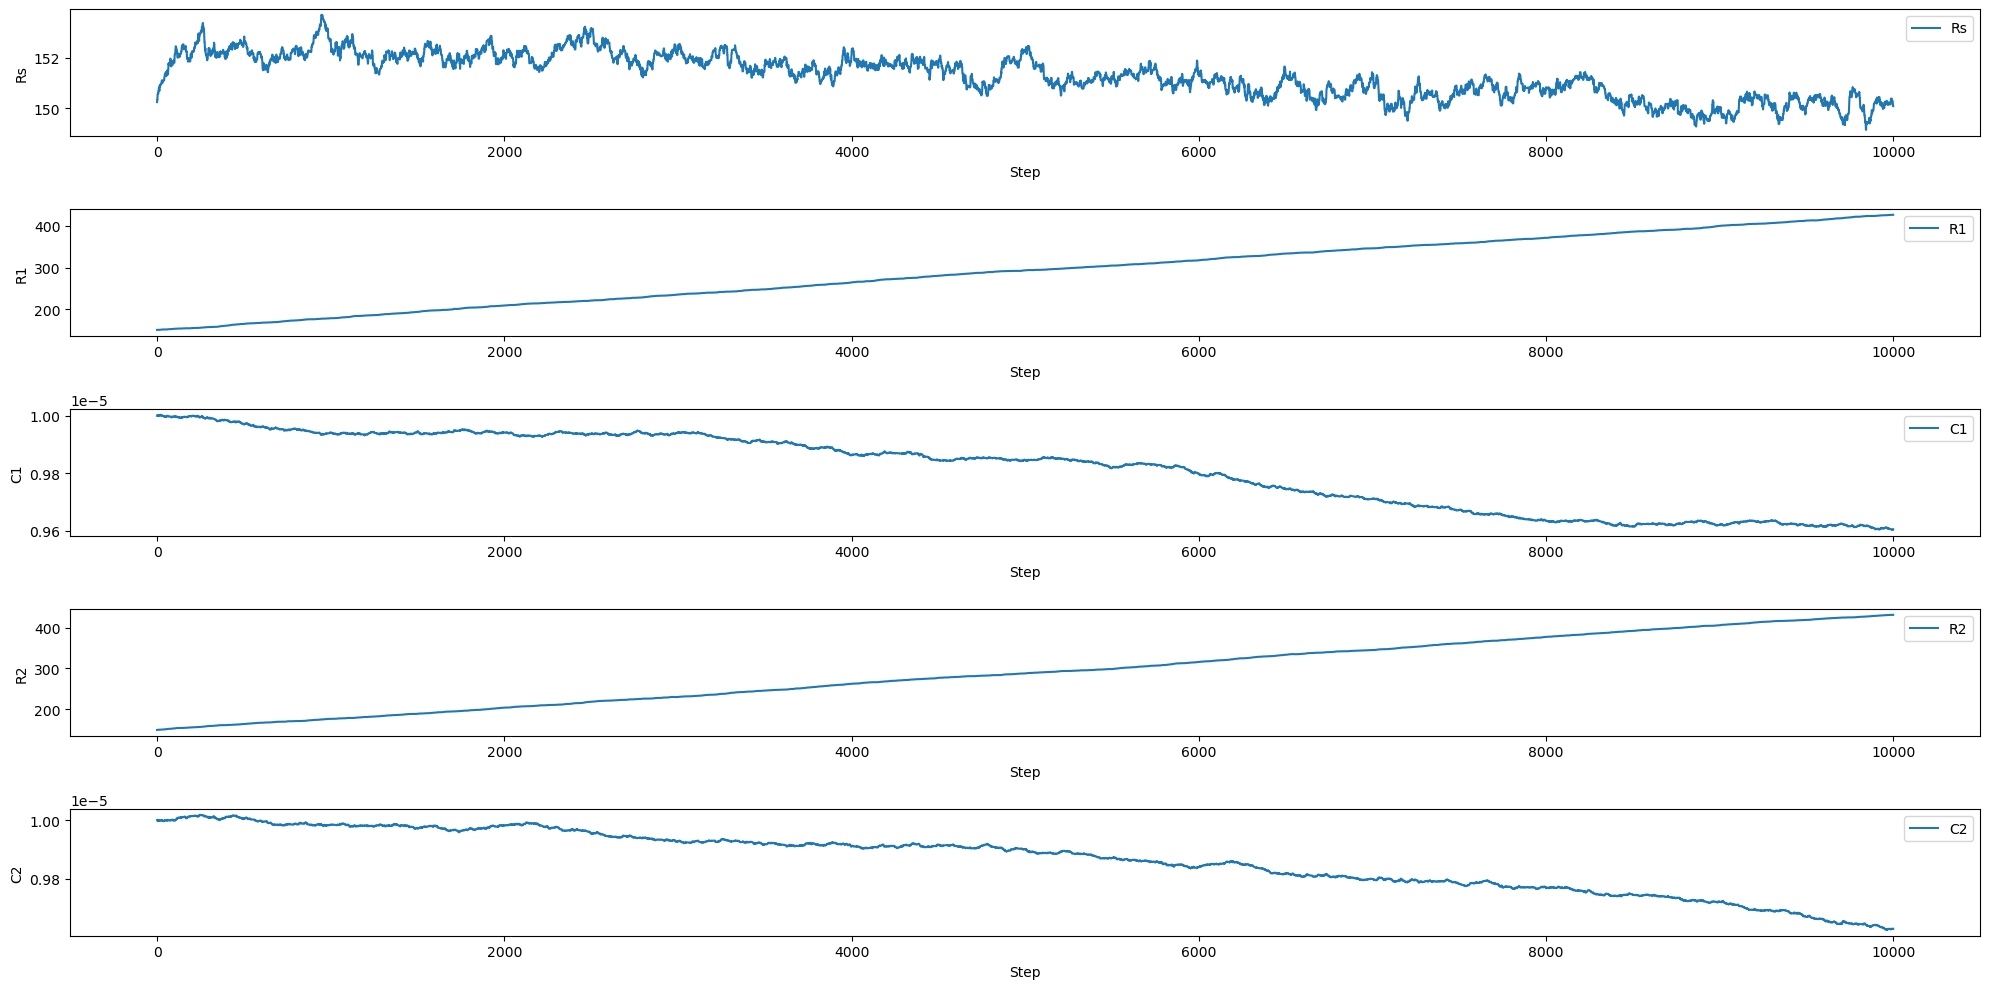

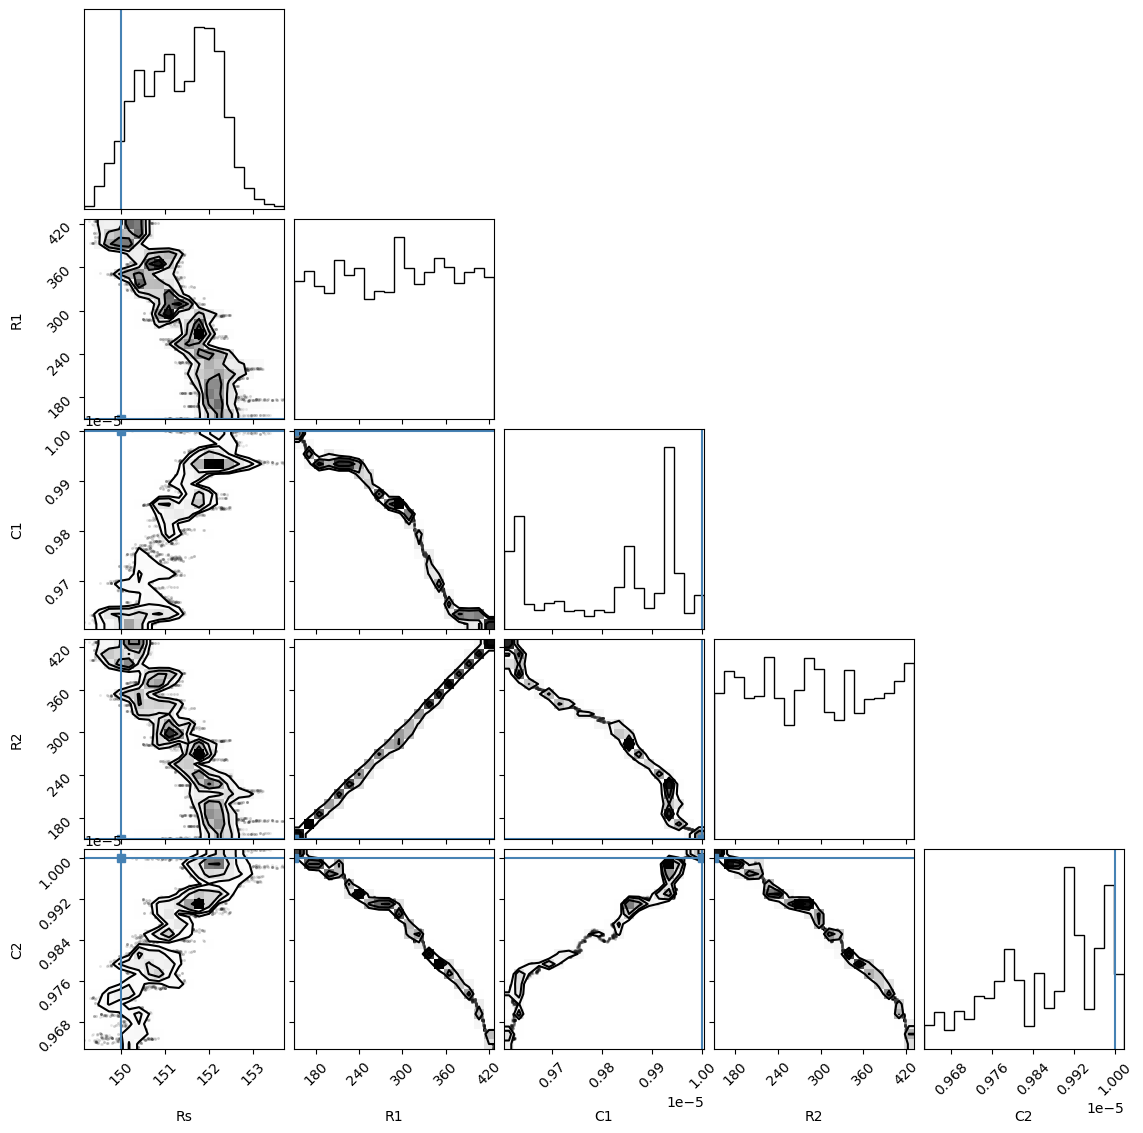

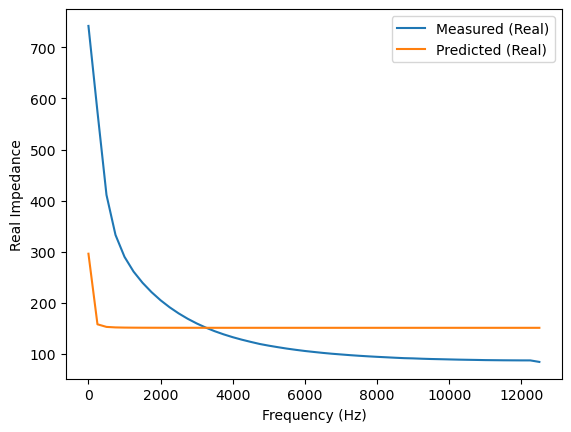

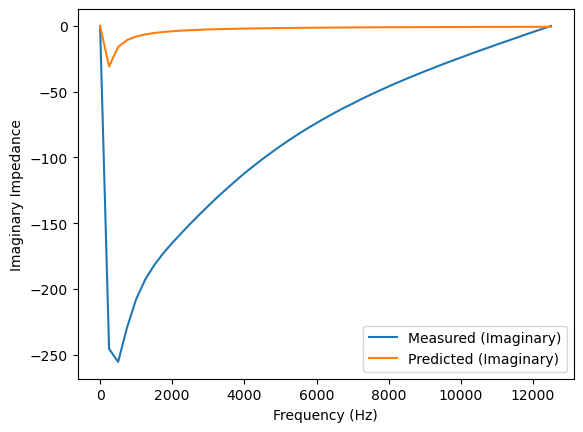

In [6]:
n_steps = 10000
samples, acceptance_rate = metropolis(frequencies, Z_real_measured, Z_imag_measured, n_steps)

# Print acceptance rate
print(f"Acceptance Rate: {acceptance_rate * 100:.2f}%")

# Extract samples
Rs_samples = samples[:, 0]
R1_samples = samples[:, 1]
C1_samples = samples[:, 2]
R2_samples = samples[:, 3]
C2_samples = samples[:, 4]

# Trace plots
plt.figure(figsize=(20, 10))

# Trace plot for Rs
plt.subplot(5, 1, 1)
plt.plot(Rs_samples, label='Rs')
plt.xlabel('Step')
plt.ylabel('Rs')
plt.legend()

# Trace plot for R1
plt.subplot(5, 1, 2)
plt.plot(R1_samples, label='R1')
plt.xlabel('Step')
plt.ylabel('R1')
plt.legend()

# Trace plot for C1
plt.subplot(5, 1, 3)
plt.plot(C1_samples, label='C1')
plt.xlabel('Step')
plt.ylabel('C1')
plt.legend()

# Trace plot for R2
plt.subplot(5, 1, 4)
plt.plot(R2_samples, label='R2')
plt.xlabel('Step')
plt.ylabel('R2')
plt.legend()

# Trace plot for C2
plt.subplot(5, 1, 5)
plt.plot(C2_samples, label='C2')
plt.xlabel('Step')
plt.ylabel('C2')
plt.legend()

plt.tight_layout()
plt.show()

# Corner plot
import corner
corner.corner(samples, labels=["Rs", "R1", "C1", "R2", "C2"], truths=[150, 150, 1e-5, 150, 1e-5])
plt.show()

# Predicted vs Measured Impedance
best_params = np.mean(samples, axis=0)
Z_real_pred, Z_imag_pred = impedance_model(frequencies, *best_params)

plt.figure()
plt.plot(frequencies, Z_real_measured, label="Measured (Real)")
plt.plot(frequencies, Z_real_pred, label="Predicted (Real)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Real Impedance")
plt.legend()
plt.show()

plt.figure()
plt.plot(frequencies, Z_imag_measured, label="Measured (Imaginary)")
plt.plot(frequencies, Z_imag_pred, label="Predicted (Imaginary)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Imaginary Impedance")
plt.legend()
plt.show()


Rs: Mean = 151.2970, Std = 0.8514
R1: Mean = 290.0770, Std = 79.7286
C1: Mean = 0.0000, Std = 0.0000
R2: Mean = 289.8312, Std = 82.3571
C2: Mean = 0.0000, Std = 0.0000


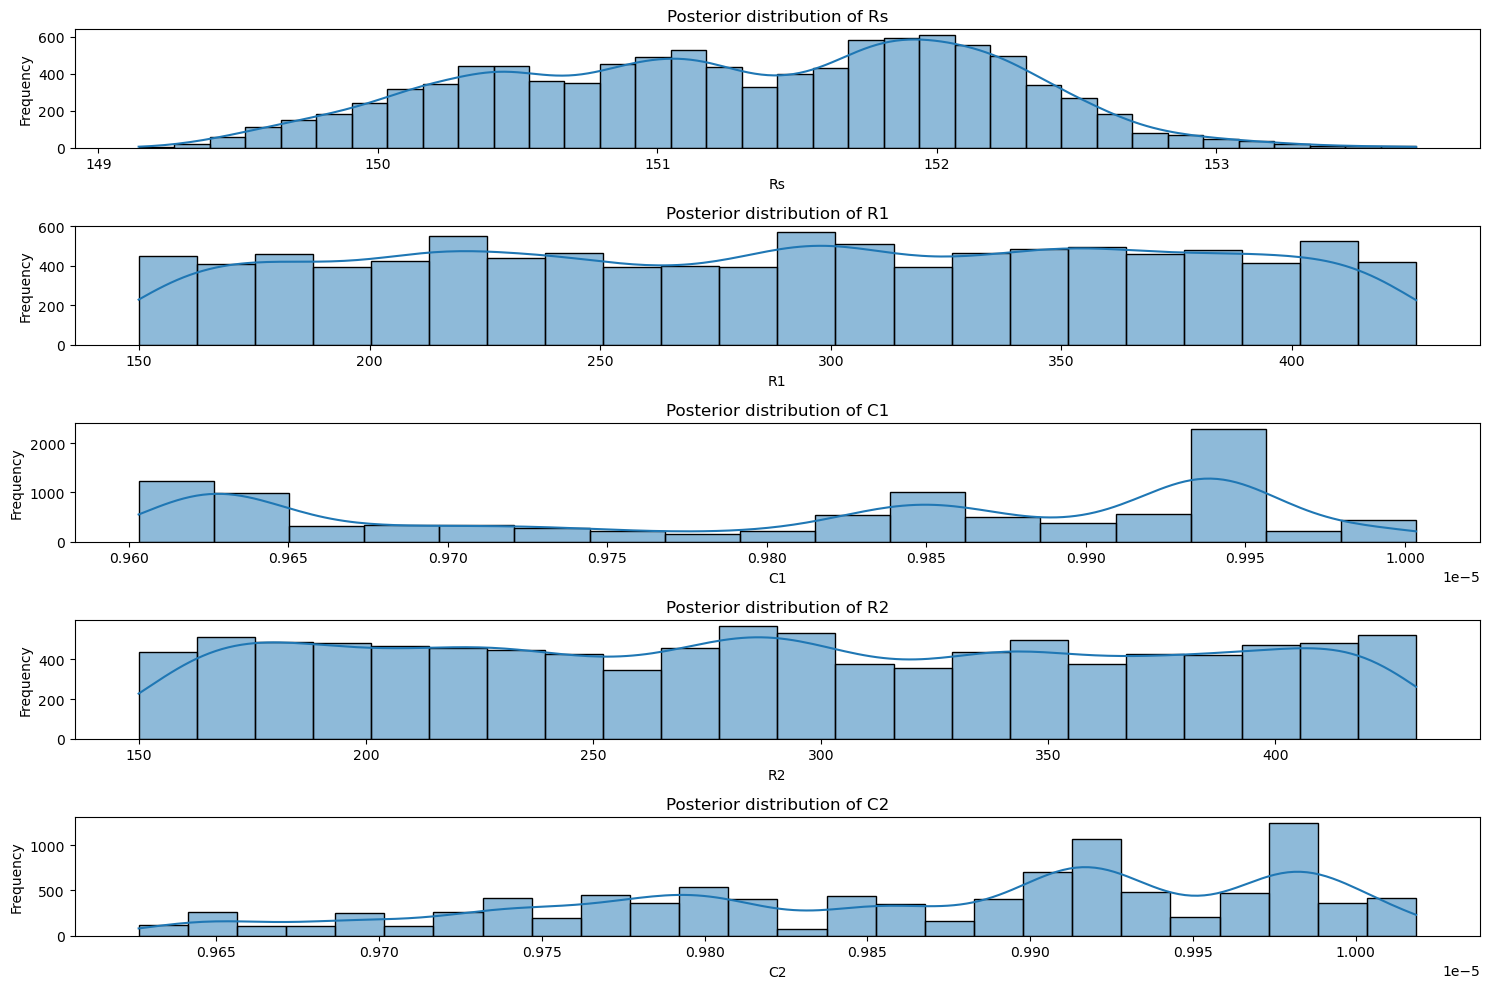

In [7]:
import seaborn as sns

# Import necessary libraries

# Function to plot histograms and calculate summary statistics
def analyze_posterior(samples, param_names):
    """
    Analyze the posterior distributions of the sampled parameters.
    
    Parameters:
    samples (numpy.ndarray): Array of sampled parameters.
    param_names (list): List of parameter names.
    """
    num_params = samples.shape[1]
    plt.figure(figsize=(15, 10))
    
    for i in range(num_params):
        plt.subplot(num_params, 1, i + 1)
        sns.histplot(samples[:, i], kde=True)
        plt.title(f'Posterior distribution of {param_names[i]}')
        plt.xlabel(param_names[i])
        plt.ylabel('Frequency')
        
        mean = np.mean(samples[:, i])
        std = np.std(samples[:, i])
        print(f'{param_names[i]}: Mean = {mean:.4f}, Std = {std:.4f}')
    
    plt.tight_layout()
    plt.show()

# Parameter names
param_names = ["Rs", "R1", "C1", "R2", "C2"]

# Analyze posterior distributions
analyze_posterior(samples, param_names)

In [8]:
# Calculate the log-likelihood for the best parameters
log_likelihood_value = log_likelihood(best_params, frequencies, Z_real_measured, Z_imag_measured)

# Print the log-likelihood value
print(f"Log-Likelihood: {log_likelihood_value}")

Log-Likelihood: -586360.8833939701
